In [1]:
# import necessary modules
from classy import Class
from math import pi

In [2]:
#####################################################
#
# Cosmological parameters and other CLASS parameters
#
#####################################################
common_settings = {# LambdaCDM parameters
                   'h':0.67810,
                   'omega_b':0.02238280,
                   'omega_cdm':0.12038,
                   'A_s':2.100549e-09,
                   'n_s': 0.9660499,
                   'tau_reio':0.05430842,
                   # output and precision parameters
                   'output':'tCl,mTk,vTk',
                   'l_max_scalars':5000,
                   'P_k_max_1/Mpc':10.0,
                   'gauge':'newtonian'
                   }

In [3]:
###############
#
# call CLASS a first time just to compute z_rec (will compute transfer functions at default: z=0)
#
###############
M = Class()
M.set(common_settings)
M.compute()
derived = M.get_current_derived_parameters(['z_rec','tau_rec','conformal_age'])
print (derived.keys())
z_rec = derived['z_rec']
z_rec = int(1000.*z_rec)/1000. # round down at 4 digits after coma
print ('z_rec=',z_rec)
#
# In the last figure the x-axis will show l/(tau_0-tau_rec), so we need (tau_0-tau_rec) in units of [Mpc/h]
#
tau_0_minus_tau_rec_hMpc = (derived['conformal_age']-derived['tau_rec'])*M.h()

dict_keys(['z_rec', 'tau_rec', 'conformal_age'])
z_rec= 1088.794


In [4]:
################
#
# call CLASS again for the perturbations (will compute transfer functions at input value z_rec)
#
################
M.empty() # reset input parameters to default, before passing a new parameter set
M.set(common_settings)
M.set({'z_pk':z_rec})
M.compute()
#
# save the total Cl's (we will plot them in the last step)
#
cl_tot = M.raw_cl(5000)
#
#
# load transfer functions at recombination
#
one_time = M.get_transfer(z_rec)
print (one_time.keys())
k = one_time['k (h/Mpc)']
Theta0 = 0.25*one_time['d_g']
phi = one_time['phi']
psi = one_time['psi']
theta_b = one_time['t_b']
# compute related quantitites
R = 3./4.*M.Omega_b()/M.Omega_g()/(1+z_rec)  # R = 3/4 * (rho_b/rho_gamma) at z_rec
zero_point = -(1.+R)*psi                     # zero point of oscillations: -(1.+R)*psi
Theta0_amp = max(Theta0.max(),-Theta0.min()) # Theta0 oscillation amplitude (for vertical scale of plot)
print ('At z_rec: R=',R,', Theta0_amp=',Theta0_amp)

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_m', 'd_tot', 'phi', 'psi', 't_g', 't_b', 't_cdm', 't_ur', 't_tot'])
At z_rec: R= 0.6228891803968909 , Theta0_amp= 0.9950203209013969


In [5]:
# use table of background quantitites to find the wavenumbers corresponding to
# Hubble crossing (k = 2 pi a H), sound horizon crossing (k = 2pi / rs)
#
background = M.get_background() # load background table
print (background.keys())
#
background_tau = background['conf. time [Mpc]'] # read confromal times in background table
background_z = background['z'] # read redshift
background_kh = 2.*pi*background['H [1/Mpc]']/(1.+background['z'])/M.h() # read kh = 2pi aH = 2pi H/(1+z) converted to [h/Mpc]
background_ks = 2.*pi/background['comov.snd.hrz.']/M.h() # read ks = 2pi/rs converted to [h/Mpc]
#
# define interpolation functions; we want the value of tau when the argument is equal to 2pi
#
from scipy.interpolate import interp1d
kh_at_tau = interp1d(background_tau,background_kh)
ks_at_tau = interp1d(background_tau,background_ks)
#
# finally get these scales
#
tau_rec = derived['tau_rec']
kh = kh_at_tau(tau_rec)
ks = ks_at_tau(tau_rec)
print ('at tau_rec=',tau_rec,', kh=',kh,', ks=',ks)

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
at tau_rec= 280.5101151849783 , kh= 0.04428066793126505 , ks= 0.0641501792962798


In [6]:
#####################
#
# call CLASS with TSW (intrinsic temperature + Sachs-Wolfe) and save
#
#####################
M.empty()           # clean input
M.set(common_settings) # new input
M.set({'temperature contributions':'tsw'})
M.compute()
cl_TSW = M.raw_cl(5000)

In [7]:
######################
#
# call CLASS with early ISW and save
#
######################
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'eisw'})
M.compute()
cl_eISW = M.raw_cl(5000)

In [8]:
######################
#
# call CLASS with late ISW and save
#
######################
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'lisw'})
M.compute()
cl_lISW = M.raw_cl(5000)

In [9]:
######################
#
# call CLASS with Doppler and save
#
######################
M.empty()
M.set(common_settings)
M.set({'temperature contributions':'dop'})
M.compute()
cl_Doppler = M.raw_cl(5000)

In [10]:
# modules and esthetic definitions for the plots
#
# uncomment to get plots displayed in notebook
%matplotlib inline
#
import matplotlib
import matplotlib.pyplot as plt
#
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

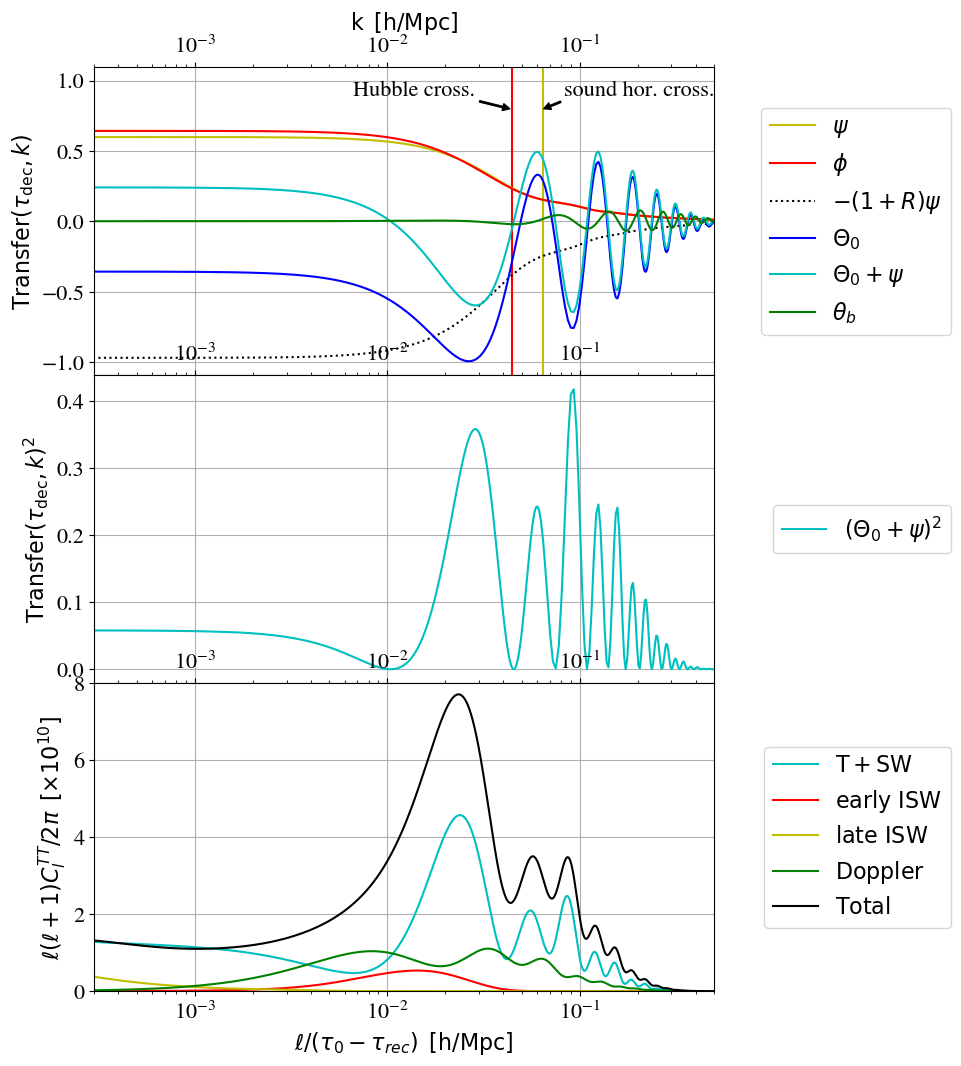

In [11]:
#################
#
# start plotting
#
#################
#
fig, (ax_Tk, ax_Tk2, ax_Cl) = plt.subplots(3,sharex=True,figsize=(8,12))
fig.subplots_adjust(hspace=0)
##################
#
# first figure with transfer functions
#
##################
ax_Tk.set_xlim([3.e-4,0.5])
ax_Tk.set_ylim([-1.1*Theta0_amp,1.1*Theta0_amp])
ax_Tk.tick_params(axis='x',which='both',bottom='off',top='on',labelbottom='off',labeltop='on')
ax_Tk.set_xlabel(r'$\mathrm{k} \,\,\,  \mathrm{[h/Mpc]}$')
ax_Tk.set_ylabel(r'$\mathrm{Transfer}(\tau_\mathrm{dec},k)$')
ax_Tk.xaxis.set_label_position('top')
ax_Tk.grid()
#
ax_Tk.axvline(x=kh,color='r')
ax_Tk.axvline(x=ks,color='y')
#
ax_Tk.annotate(r'Hubble cross.',
                xy=(kh,0.8*Theta0_amp),
                xytext=(0.15*kh,0.9*Theta0_amp),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
ax_Tk.annotate(r'sound hor. cross.',
                 xy=(ks,0.8*Theta0_amp),
                 xytext=(1.3*ks,0.9*Theta0_amp),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headlength=5, headwidth=5))
#
ax_Tk.semilogx(k,psi,'y-',label=r'$\psi$')
ax_Tk.semilogx(k,phi,'r-',label=r'$\phi$')
ax_Tk.semilogx(k,zero_point,'k:',label=r'$-(1+R)\psi$')
ax_Tk.semilogx(k,Theta0,'b-',label=r'$\Theta_0$')
ax_Tk.semilogx(k,(Theta0+psi),'c',label=r'$\Theta_0+\psi$')
ax_Tk.semilogx(k,theta_b,'g-',label=r'$\theta_b$')
#
ax_Tk.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
#######################
#
# second figure with transfer functions squared
#
#######################
ax_Tk2.set_xlim([3.e-4,0.5])
ax_Tk2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off',labeltop='off')
ax_Tk2.set_ylabel(r'$\mathrm{Transfer}(\tau_\mathrm{dec},k)^2$')
ax_Tk2.grid()
#
ax_Tk2.semilogx(k,(Theta0+psi)**2,'c',label=r'$(\Theta_0+\psi)^2$')
#
ax_Tk2.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
########################
#
# third figure with all contributions to Cls
#
# We already computed each contribution (TSW, earlyISW, lateISW, Doppler, total)
# Note that there is another contribution from polarisation. We don't plot it because it is
# too small to be seen, however it is included by default in the total.
#
# After each step we will save the figure (to get intermediate figures that can be used in slides)
#
#########################
# presentation settings
ax_Cl.set_xlim([3.e-4,0.5])
ax_Cl.set_ylim([0.,8.])
ax_Cl.set_xlabel(r'$\ell/(\tau_0-\tau_{rec}) \,\,\, \mathrm{[h/Mpc]}$')
ax_Cl.set_ylabel(r'$\ell (\ell+1) C_l^{TT} / 2 \pi \,\,\, [\times 10^{10}]$')
ax_Cl.tick_params(axis='x',which='both',bottom='on',top='off',labelbottom='on',labeltop='off')
ax_Cl.grid()
#
# plot and save with TSW
#
ax_Cl.semilogx(cl_TSW['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_TSW['ell']*(cl_TSW['ell']+1.)*cl_TSW['tt']/2./pi,'c-',label=r'$\mathrm{T+SW}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_1.pdf',bbox_inches='tight')
#
# plot and save with additionally early ISW and late ISW
#
ax_Cl.semilogx(cl_eISW['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_eISW['ell']*(cl_eISW['ell']+1.)*cl_eISW['tt']/2./pi,'r-',label=r'$\mathrm{early} \,\, \mathrm{ISW}$')
ax_Cl.semilogx(cl_lISW['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_lISW['ell']*(cl_lISW['ell']+1.)*cl_lISW['tt']/2./pi,'y-',label=r'$\mathrm{late} \,\, \mathrm{ISW}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_2.pdf',bbox_inches='tight')
#
# plot and save with additionally Doppler
#
ax_Cl.semilogx(cl_Doppler['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_Doppler['ell']*(cl_Doppler['ell']+1.)*cl_Doppler['tt']/2./pi,'g-',label=r'$\mathrm{Doppler}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_3.pdf',bbox_inches='tight')
#
# plot and save with additionally total Cls
#
ax_Cl.semilogx(cl_tot['ell']/tau_0_minus_tau_rec_hMpc,1.e10*cl_tot['ell']*(cl_tot['ell']+1.)*cl_tot['tt']/2./pi,'k-',label=r'$\mathrm{Total}$')
#
ax_Cl.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
fig.savefig('one_time_with_cl_tot.pdf',bbox_inches='tight')